# Assignment 8: Times Series Analysis

In assignment 8 we perform time series analysis for milk production using the California dairy production data set to address the following questions:

1. Is the time series stationary?
2. Is there a significant seasonal component?
3. For the residual from the STL decomposition of the time series, what is the order of the ARMA(p,q) process that best fits?

We then forecast production for 12 months, reporting numeric values and plotting the confidence intervals. We try to answer:

1. Are the confidence intervals reasonably small compared to the forecast means?
2. How do the confidence intervals behave as time moves to the future?

### Preparation

Import required libraries:

In [30]:
import pandas as pd
import numpy as np
import scipy.stats as ss
import statsmodels.graphics.tsaplots as splt
import statsmodels.tsa.arima_process as arima
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
import statsmodels.tsa.seasonal as sts
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
import matplotlib.pyplot as plt

Define global options:

In [31]:
# Display plots inline
%matplotlib inline

# Display all outputs from cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Declare functions:

In [32]:
# Plots the given time series
def plot_ts(ts, lab=''):
    ts.plot()
    plt.title('Time series plot of ' + lab)
    plt.ylabel('Value')
    plt.xlabel('Date')

# Plots seasonal time series
def decomp_ts(ts, freq='M', model='additive'):
    res = sts.seasonal_decompose(ts, model = model) 
    res.plot()
    return(pd.DataFrame({'resid': res.resid, 
                         'trend': res.trend, 
                         'seasonal': res.seasonal},
                         index = ts.index))

# Performs the Dicky Fuller test with a trend parameter and prints the results
def DF_Test(ts, trend='ct'):
    stationary = adfuller(ts, regression=trend)

    ## Print the results
    print('D-F statistic = ' + str(stationary[0]))
    print('p-value = ' + str(stationary[1]))
    print('number of lags used = ' + str(stationary[2]))
    print('Critical value at 5% confidence = ' + str(stationary[4]['5%']))
    print('Critical value at 10% confidence = ' + str(stationary[4]['10%']))

### Load the Data Set

We begin by loading the data set:

In [33]:
# Internet location of the data set
url = "https://library.startlearninglabs.uw.edu/DATASCI410/Datasets/CADairyProduction.csv"

# Download the data into a dataframe object
dairy = pd.read_csv(url)

dairy

,Year,Month,Cotagecheese.Prod,Icecream.Prod,Milk.Prod,N.CA.Fat.Price,Month.Count,monthNumSqred,monthNumCubed
0,1995,Jan,4.370,51.595,2.112,0.9803,1,1,1
1,1995,Feb,3.695,56.086,1.932,0.8924,2,4,8
2,1995,Mar,4.538,68.453,2.162,0.8924,3,9,27
3,1995,Apr,4.280,65.722,2.130,0.8967,4,16,64
4,1995,May,4.470,73.730,2.227,0.8967,5,25,125
...,...,...,...,...,...,...,...,...,...
223,2013,Aug,2.169,78.382,3.400,1.6273,224,50176,11239424
224,2013,Sep,2.193,74.871,3.197,1.5519,225,50625,11390625
225,2013,Oct,2.284,70.011,3.338,1.5566,226,51076,11543176
226,2013,Nov,1.865,61.394,3.275,1.7537,227,51529,11697083


In this assignment we focus on milk production.

### Is Milk Production Stationary?

We now seek to answer the question as to whether milk production is stationary. First, we load the data into a series and plot:

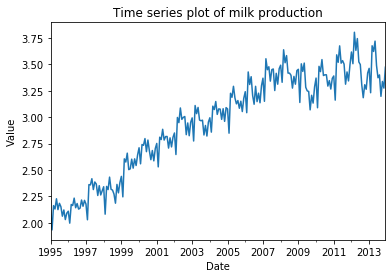

In [34]:
# Define date range for milk production
dates = pd.date_range(start='1-1995', end='1-2014', freq='M')

# Load data as a series
milk = pd.Series(dairy['Milk.Prod'].values, index=dates)

# Plot data
plot_ts(milk, 'milk production')

 Now we look for trends in the autocorrelation function (ACF) and partial autocorrelation function (PACF):

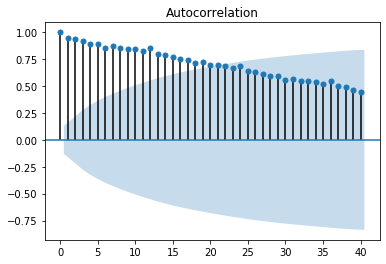

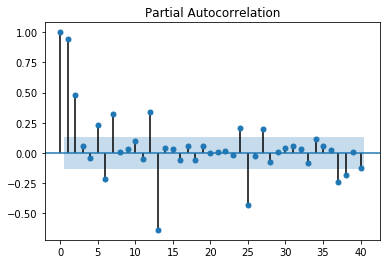

In [35]:
# Plot the ACF and PACF
_=splt.plot_acf(milk, lags = 40)
_=splt.plot_pacf(milk, lags = 40)

Note that the ACF decays steadily and the PACF exhibits significant values for several lags, showing that the trend creates a dependency from one value to the next. Hence, the time series for milk production is **not stationary**.

### Is Milk Production Seasonal? STL Decomposition

We now determine if milk production has a seasonal component by examining the observed data against the trend, seasonal, and residual elements obtained using a decomposition model. We perform STL decomposition on the **additive values of the model** (vs the multiplicative values) to detect any underlying seasonal pattern of the data:

               resid     trend  seasonal
1995-01-31       NaN       NaN  0.027271
1995-02-28       NaN       NaN -0.179759
1995-03-31       NaN       NaN  0.144447
1995-04-30       NaN       NaN  0.079891
1995-05-31       NaN       NaN  0.163026
1995-06-30       NaN       NaN  0.011056
1995-07-31  0.053120  2.110458  0.020421
1995-08-31  0.035155  2.113000  0.003845
1995-09-30  0.065041  2.116125 -0.119166
1995-10-31  0.027444  2.117958 -0.024403
1995-11-30  0.028062  2.119583 -0.117646
1995-12-31 -0.020600  2.120583 -0.008984


,resid,trend,seasonal
2013-01-31,0.008687,3.426042,0.027271
2013-02-28,-0.014074,3.424833,-0.179759
2013-03-31,0.102178,3.429375,0.144447
2013-04-30,0.110900,3.431208,0.079891
2013-05-31,0.124016,3.432958,0.163026
2013-06-30,0.042236,3.435708,0.011056
2013-07-31,NaN,NaN,0.020421
2013-08-31,NaN,NaN,0.003845
2013-09-30,NaN,NaN,-0.119166
2013-10-31,NaN,NaN,-0.024403


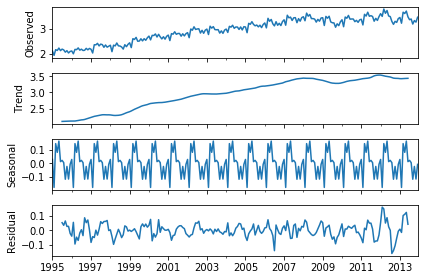

In [36]:
decomp = decomp_ts(milk, model='additive')
print(decomp[:12])
decomp[-12:]

After decomposing the time series into three components, we examine the seasonal component. The sinoidal pattern of the seasonal component reveals a **clear seasonal fluctuation** in milk production. This is not surprising dairy production is an agricultural industry.

### STL Decomposition Residuals

We apply the **Dicky Fuller test** to test the stationarity of the residuals with the null hypothesis being that the time series is not stationary. Because there is a trend we supply a trend parameter:

In [37]:
DF_Test(decomp.resid[6:-6], trend='ct')

D-F statistic = -5.117433129258908
p-value = 0.0001250642352186112
number of lags used = 14
Critical value at 5% confidence = -3.432562031417379
Critical value at 10% confidence = -3.1400135886063114


The negative D-F statistic and low p-value suggest that we cannot reject the null hypothesis that the residuals are not stationary. Therefore, we cannot rule out the possibility that **the residuals are stationary**.

### Find a Best Fit Model Using ARIMA

We now find a best fit model using the auto_arima function from the pmdarima package:

In [38]:
log_milk = milk[:'12-2012']
best_model = pm.auto_arima(log_milk, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           information_criterion = 'bic',
                           error_action='ignore',  # don't want to know if an order does not work
                           suppress_warnings=True,  # don't want convergence warnings
                           stepwise=True)  # set to stepwise

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=-640.641, BIC=-624.075, Fit time=3.552 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=-565.684, BIC=-559.058, Fit time=0.168 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=-606.854, BIC=-593.601, Fit time=1.582 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=-640.893, BIC=-627.640, Fit time=3.356 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=-639.198, BIC=-622.631, Fit time=3.813 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=-567.951, BIC=-558.011, Fit time=0.328 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=-639.393, BIC=-622.827, Fit time=8.364 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=-636.948, BIC=-617.069, Fit time=6.509 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 12); AIC=-638.421, BIC=-628.481, Fit time=0.804 seconds
Fit ARIMA: order=(0, 1, 0) s

Next we examine a summary of the best fit model:

In [39]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  216
Model:             SARIMAX(0, 1, 0)x(0, 1, 1, 12)   Log Likelihood                 322.210
Date:                            Sat, 07 Mar 2020   AIC                           -638.421
Time:                                    17:57:02   BIC                           -628.481
Sample:                                         0   HQIC                          -634.399
                                            - 216                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0004      0.001     -0.377      0.706      -0.003       0.002
ma.S.L12      -0.7115      0.051    -14.025      0.000      -0.811      -0.612
sigma2         0.0023      0.000     13.411      0.000       0.002       0.003
===================================================================================
Ljung-Box (Q):                       52.06   Jarque-Bera (JB):                20.27
Prob(Q):                              0.10   Prob(JB):                         0.00
Heteroskedasticity (H):               1.36   Skew:                            -0.01
Prob(H) (two-sided):                  0.20   Kurtosis:                         4.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**The ma coefficient is statistically significant** given its low standard error (0.051), the low p-value (P>|z| = 0.0), and the tight confidence interval that does not straddle zero.

### Forecast the Last 12 Months

We now leverage our model to forecast the last 12 months of the series:

In [40]:
prediction = pd.Series(best_model.predict(n_periods=12), 
                       index=pd.date_range(start='1-2013', end='1-2014', freq='M'))
prediction

2013-01-31    3.480619
2013-02-28    3.277386
2013-03-31    3.632533
2013-04-30    3.529474
2013-05-31    3.634812
2013-06-30    3.453382
2013-07-31    3.450386
2013-08-31    3.391238
2013-09-30    3.247856
2013-10-31    3.355694
2013-11-30    3.281339
2013-12-31    3.420590
Freq: M, dtype: float64

Next we plot the predicted values against the actual values:

Text(0.5, 1.0, 'Full milk production with predicted values')

Text(0, 0.5, 'Milk production')

Text(0.5, 0, 'Date')

Text(0.5, 1.0, 'Milk production for 12 months\nwith predicted values')

Text(0.5, 0, 'Date')

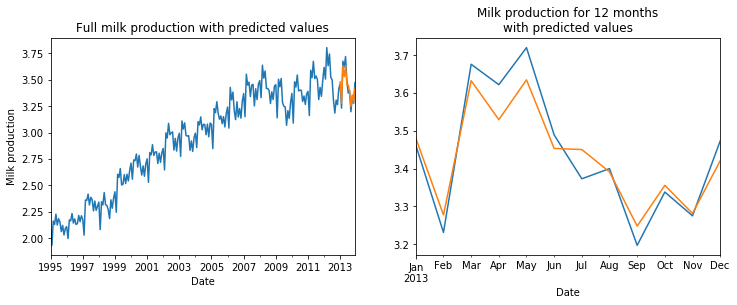

In [41]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
milk.plot(ax=ax[0])
prediction.plot(ax=ax[0])
ax[0].set_title('Full milk production with predicted values')
ax[0].set_ylabel('Milk production')
ax[0].set_xlabel('Date')

milk['1-2013':].plot(ax=ax[1])
prediction.plot(ax=ax[1])
ax[1].set_title('Milk production for 12 months\nwith predicted values')
ax[1].set_xlabel('Date')

It turns out **the predicted values are quite close to the actual values**. Only in July do the predicted values go in a different direction than the actual values. Otherwise, the predicted values go up and down in sync with the actual values.

### Forecast Residuals

We now look at the residuals and their standard deviation (RMSE):

In [42]:
residuals = milk['1-2013':] - prediction
print(residuals)
print('\nThe STD of the residuals = {}'.format(np.round(np.std(residuals), 3)))

2013-01-31   -0.018619
2013-02-28   -0.046386
2013-03-31    0.043467
2013-04-30    0.092526
2013-05-31    0.085188
2013-06-30    0.035618
2013-07-31   -0.077386
2013-08-31    0.008762
2013-09-30   -0.050856
2013-10-31   -0.017694
2013-11-30   -0.006339
2013-12-31    0.052410
Freq: M, dtype: float64

The STD of the residuals = 0.052


Both **the residuals and their standard deviation (RMSE) are small in comparison with the values in the series** suggesting that the model is a good fit for the observed data.

Next we verify that the residuals have a normal distribution by plotting them against normal:

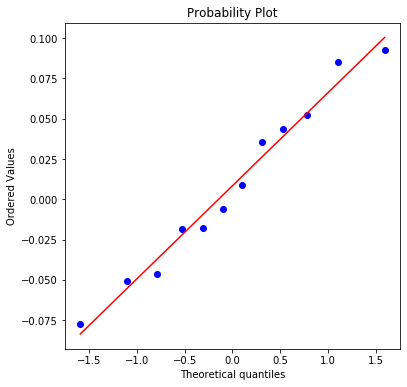

In [43]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
_=ss.probplot(residuals, plot = ax)

It is clear that the residuals are **normally distributed**.

### Conclusion

In this assignment we analyzed a time series of milk production in California from January 1995 through December 2013. We determined that the time series was not stationary since it exhibits a clear trend. We performed STL decomposition and found that the time series exhibits clear periodicity through the months of the year, while the residuals are possibly stationary according the Dicky Fuller test. We build an autoregressive model and found the *ma* coefficient to be statistically significant. We then forecasted the last 12 months of the series, plotting the predicted against the actual results. We found that the predictions were close to the actual observations and that the residuals were normally distributed with RMSE small relative to the forecasted values.